In [1]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
import scipy.stats as st

# set plotting theme
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/"
dpi = 600

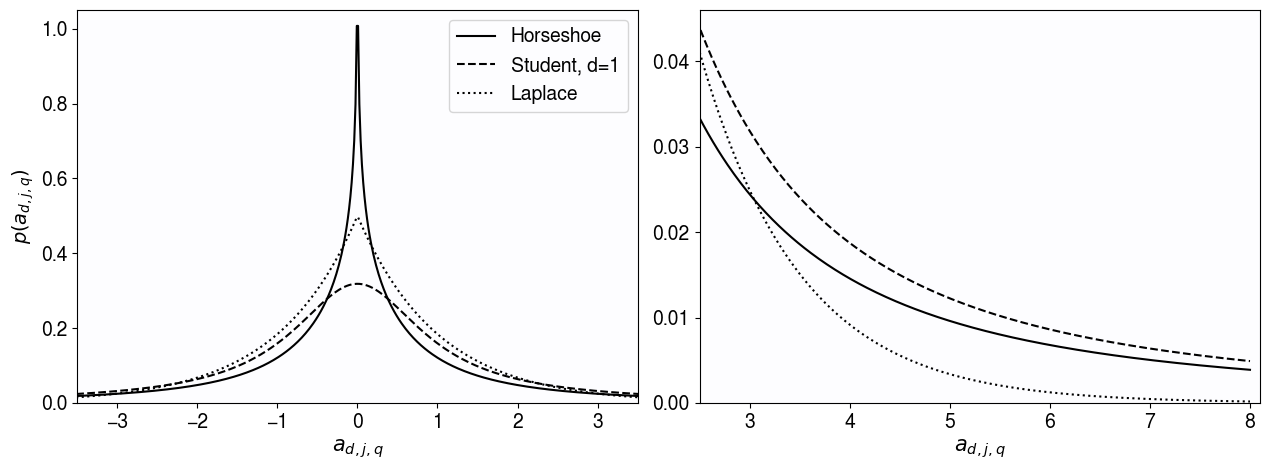

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))

theta = np.linspace(-8, 8, 1000)
hs = HorseshoePrior(1)
cauchy = dist.Cauchy(0,1) # equivalent to StudentT with one degree freedom
laplace = dist.Laplace(0,1) 
student = dist.StudentT(1,0,1.)

hs_pdf = hs.log_prob(theta).exp()
cauchy_pdf = cauchy.log_prob(torch.tensor(theta)).exp()
laplace_pdf = laplace.log_prob(torch.tensor(theta)).exp()
student_pdf = student.log_prob(torch.tensor(theta)).exp()

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[0])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[0])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[0])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[0])
ax[0].set_ylabel(r"$p(a_{d,j,q})$", fontsize=14)
ax[0].set_ylim([0, 1.05])
ax[0].set_xlim([-3.5,3.5]);
# plt.xlabel(r"$a_{d,j,q}$")
ax[0].set_xlabel(r"$a_{d,j,q}$", fontsize=15)
ax[0].legend(fontsize=14)

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[1])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[1])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[1])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[1])

ax[1].set_xlim([2.5, 8.1]);
ax[1].set_ylim([0,0.046])
ax[1].get_legend().remove()
ax[1].set_xlabel(r"$a_{d,j,q}$", fontsize=15)

ax[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust the size of the ticks
ax[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust the size of the ticks

fig.tight_layout()

filename = "lmc_prior_comparison.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)

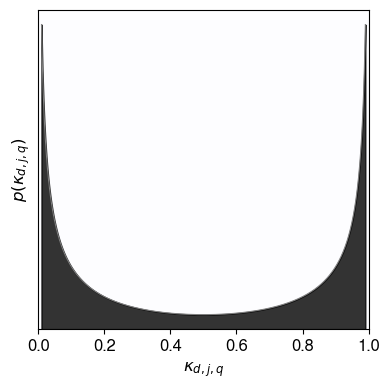

In [3]:
fig, ax = plt.subplots(figsize=(4, 4))
half_cauchy = dist.HalfCauchy(1)
ep = 1e-2
kappa = np.linspace(ep,1-ep,1000)
def kappa_prob(kappa):
    pdf = kappa**(-1/2)*(1-kappa)**(-1/2)
    return pdf

kappa_pdf = kappa_prob(kappa)
sns.lineplot(x=kappa, y=kappa_pdf, ls="solid", c="grey", ax=ax, lw=.75)
# sns.lineplot(x=kappa, y=kappa_pdf, ls="solid", c="k", ax=ax, lw=1.5)
ymin, ymax = ax.get_ylim()
ax.fill_between(kappa, ymin, kappa_pdf, color="black", alpha=.8)
ax.set_xlim(0,1)
ax.set_ylim(ymin,ymax)

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the size of the ticks
ax.set_xlabel(r"$\kappa_{d,j,q}$", fontsize=12)
ax.set_yticks([])
ax.set_ylabel(r"$p(\kappa_{d,j,q})$", fontsize=12)
# ax.set_title(r"Horseshoe prior", fontsize=12)
fig.tight_layout()

filename = "horseshoe_kappa_prior.pdf"
if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
    os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
    print("Deleted file:", filename[:-4] + ".png")
fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)